# Exploring `sales_train`

This notebook is an initial look at the `sales_train` data set. This data set holds the main target variable and foreign keys linking to extra information. 

See the GitLab issue https://gitlab.com/dougmet/rapid-repro/issues/3

## Summary

`sales_train` is a large table with nearly 3 million rows and 6 columns. The `date_block_num` is an index to make linking with the target easier. `shop_id` and `item_id` link to other tables with more information. `item_price` and `item_cnt_day` hold the data for how much was sold at what price on a given day.

The target variable is the montly item count for every single shop/item combination. There are over 400k combinations. The numbers are therefore going to be small except for a few items. Items tend to be short lived so for most items there won't be a significant useful history unless we can link them to similar items.

The data is a time series indexed on date, and keyed on `shop_id` and `item_id`. However, there is some data quality issues on about 50 rows that should be aggregated to the cleaned data set.

## Details

As always, let's refresh the pipeline to make sure we have the right data. We'll also load the tidyverse to do our EDA

In [ ]:
library(tidyverse)
options(repr.plot.width=5, repr.plot.height=3.5)

In [ ]:
library(drake)
r_make()

In [3]:
loadd("sales_train")
head(sales_train, n=10)
dim(sales_train)

date       date_block_num shop_id item_id item_price item_cnt_day
1  2013-01-02 0              59      22154    999.00     1          
2  2013-01-03 0              25       2552    899.00     1          
3  2013-01-05 0              25       2552    899.00    -1          
4  2013-01-06 0              25       2554   1709.05     1          
5  2013-01-15 0              25       2555   1099.00     1          
6  2013-01-10 0              25       2564    349.00     1          
7  2013-01-02 0              25       2565    549.00     1          
8  2013-01-04 0              25       2572    239.00     1          
9  2013-01-11 0              25       2572    299.00     1          
10 2013-01-03 0              25       2573    299.00     3

[1] 2935849       6

## Target Variable

The target variable for the final model is the item count for each `item_id` and `shop_id` in November. So that is a *monthly* count. Here we have daily count. 

### Distribution of counts

The vast majority of counts are for small positive integers (1,2,3). But we have some large positive and negative numbers in there too.


In [4]:
count(sales_train, item_cnt_day) %>% arrange(desc(n)) %>% head()

item_cnt_day n      
1  1           2629372
2  2            194201
3  3             47350
4  4             19685
5  5             10474
6 -1              7252

### Time Series

To roll this up I'm going to setup the data frame as a `tsibble` to really pull through the time series element. If this goes well we could push that up to the pipeline.

In [5]:
library(tsibble)
sales_train_ts <- as_tsibble(sales_train, key = c(shop_id, item_id), index = date)


Attaching package: 'tsibble'

The following object is masked from 'package:dplyr':

    id



ERROR: A valid tsibble must have distinct rows identified by key and index.
Please use `duplicates()` to check the duplicated rows.

The error above is because date, shop_id, and item_id is not enough to uniquely specify the time series. This is important because I would have expected this to be the case. You sell $n$ items at $x$ price and that's it. But here we are seeing sales of the same item, same shop, different price.

In [6]:
sales_dups <- duplicates(sales_train, key = c(shop_id, item_id), index = date)
dim(sales_dups)
head(sales_dups)

[1] 56  6

date       date_block_num shop_id item_id item_price item_cnt_day
1 2013-01-29 0              25      12133    889       1           
2 2013-01-29 0              25      12133   1389       1           
3 2013-01-25 0              31      14050    349       1           
4 2013-01-25 0              31      14050    248       1           
5 2013-01-05 0              54      20130    149       1           
6 2013-01-05 0              54      20130    149       1

So only 56 rows affected by this. It is probably an error somehow. Mostly it's a slightly different price and we can possibly just take a weighted price average and some the item count.  In the example below it look like a return -- perhaps it was entered incorrectly and fixed?

In [7]:
filter(sales_dups, date == "2015-02-17")

date       date_block_num shop_id item_id item_price item_cnt_day
1 2015-02-17 25             5       21619   499.00      1          
2 2015-02-17 25             5       21619   332.66     -1

As the size of this problem is small compared to the number of items in the total data frame. I propose we take a weighted sum of price and sum the count. It's a bit tricky to say how we account for returns. If we say that within the duplicated rows we call $p_i$ the `item_price` and $n_i$ is the `item_cnt_day`. For the grouping I want to make a new price, $p'$ and count, $n'$ such that $p'n' = \sum_i p_i n_i$.

$$
n' = \sum_i n_i
$$

$$
p' = \frac{ \sum_i p_i  n_i } {\sum_i n_i }
$$

The only problem is when $n' = 0$ in which case I propose we zero the price too.

In [8]:
sales_train_dedup <- sales_train %>%
  group_by(date, shop_id, item_id) %>%
  summarise(date_block_num = first(date_block_num),
            item_price = ifelse(sum(item_cnt_day) == 0, 0, sum(item_price * item_cnt_day) / sum(item_cnt_day)),
            item_cnt_day = sum(item_cnt_day)) %>%
  ungroup()

In [10]:
 filter(sales_train_dedup, date == "2015-02-17", shop_id == 5, item_id == 21619)

date       shop_id item_id date_block_num item_price item_cnt_day
1 2015-02-17 5       21619   25             0          0

We may want to think about removing these rows entirely. For other rows we just get a nice average.

In [11]:
filter(sales_train_dedup, date == "2013-01-29", shop_id == 25, item_id == 12133)

date       shop_id item_id date_block_num item_price item_cnt_day
1 2013-01-29 25      12133   0              1139       2

In [12]:
sales_train_ts <- sales_train_dedup %>%
  as_tsibble(key = c(shop_id, item_id), index = date)

In [13]:
head(sales_train_ts)

date       shop_id item_id date_block_num item_price item_cnt_day
1 2013-02-15 0       30      1              265        2           
2 2013-02-16 0       30      1              265        9           
3 2013-02-17 0       30      1              265        4           
4 2013-02-18 0       30      1              265        4           
5 2013-02-20 0       30      1              265        2           
6 2013-02-21 0       30      1              265        2

You can see that the order has been set. by the index and groupings. We can now some nifty aggrgation.

In [15]:
sales_monthly <- sales_train_ts %>%
  index_by(yearmon = yearmonth(date)) %>%
  summarise(date_block_num = first(date_block_num),
            mean_price = sum(item_price * item_cnt_day) / sum(item_cnt_day),
            gross_sales = sum(item_price),
            item_cnt_month = sum(item_cnt_day))

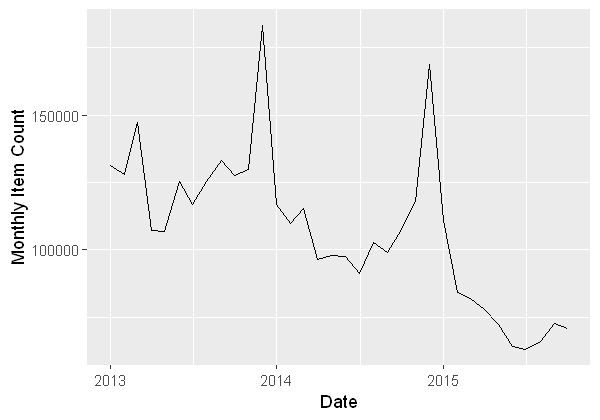

In [16]:
ggplot(sales_monthly, aes(x = yearmon, y = item_cnt_month)) +
  geom_line() + labs(y = "Monthly Item Count", x = "Date")

So overall there is a seasonal pattern as you'd expect, and a general trend of dropping sales numbers. Is that the same in terms of revenue? I actually don't know the currency. Could be rubles or USD at a guess.

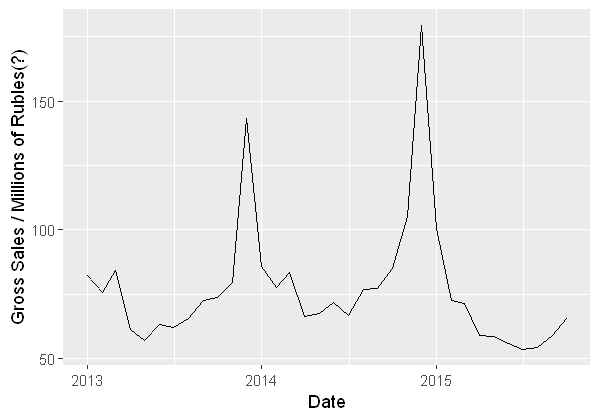

In [17]:
ggplot(sales_monthly, aes(x = yearmon, y = gross_sales / 1e6)) +
  geom_line() + labs(y = "Gross Sales / Millions of Rubles(?)", x = "Date")

Interstingly the gross sales is going up. So they're selling less of more expensive items.

## Shop/Item Combinations

One our challenges is that we are not predicting a single gross time series. But rather combinations of `shop_id` and `item_id`. There are lot of possibilities.

In [18]:
# Total observations
dim(sales_train_ts)

[1] 2935821       6

In [19]:
# Unique shop/item combinations
distinct(sales_train_ts, shop_id, item_id) %>% dim()

[1] 424124      2

So that's 400k combinations of shop and item ID. What about separately?

### Shops

In [20]:
shop_count <- count(sales_train_ts, shop_id)
shop_count %>% head()

shop_id date       n  
1 0       2013-01-03 174
2 0       2013-01-04 272
3 0       2013-01-05 236
4 0       2013-01-06 177
5 0       2013-01-07 116
6 0       2013-01-08 211

I'm leaving this here because it shows that with a tsibble it's hard to remove the index variable. Let's try:

In [21]:
shop_count <- sales_train_ts %>%
  as_tibble %>%
  count(shop_id)
shop_count %>% head()
shop_count %>% dim()

shop_id n    
1 0        9857
2 1        5678
3 2       25991
4 3       25532
5 4       38242
6 5       38178

[1] 60  2

OK so we can convert back. We've got 60 unique shops. And their total sales

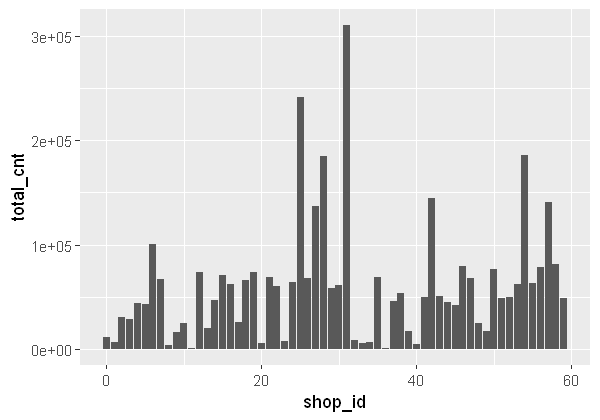

In [22]:
shop_total <- sales_train_ts %>%
  as_tibble %>%
  group_by(shop_id) %>%
  summarise(total_cnt = sum(item_cnt_day))

ggplot(shop_total, aes(x = shop_id, y = total_cnt)) +
  geom_bar(stat = "identity")

So quite a spread from biggest to smallest.

In [23]:
range(shop_total$total_cnt)

[1]    330 310777

### Items

Same for items

In [24]:
item_count <- sales_train_ts %>%
  as_tibble %>%
  count(item_id)
item_count %>% head()
item_count %>% dim()

item_id n
1 0       1
2 1       6
3 2       2
4 3       2
5 4       1
6 5       1

[1] 21807     2

A whopping 21k separate items! The majority do not appear very often.

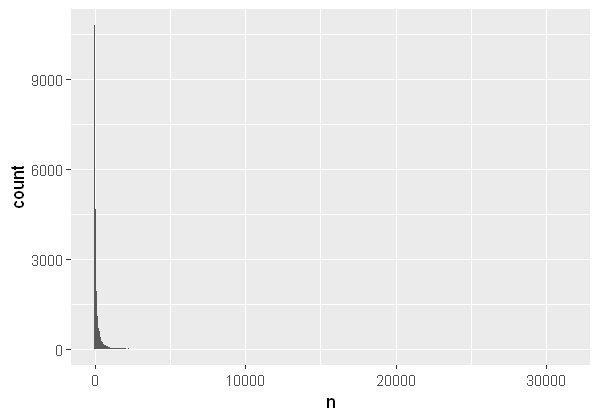

In [25]:
ggplot(item_count) + geom_histogram(aes(x=n), bins = 500)

So for individual products can we see their time series?

In [26]:
item_ts <- sales_train_ts %>%
  index_by(yearmon = yearmonth(date)) %>%
  group_by(item_id) %>%
  summarise(item_cnt_month = sum(item_cnt_day))

The vast majority don't really have anything worth plotting!

In [27]:
item_ts %>%
  filter(item_id == 14) 

item_id yearmon  item_cnt_month
1 14      2014 Dec 1

Some have more but the item launches and then rapidly tails off.

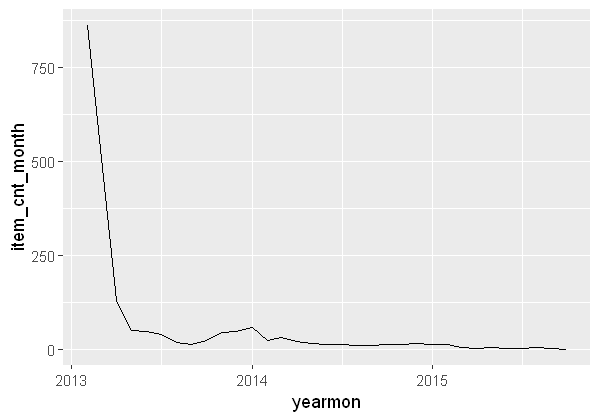

In [28]:
item_ts %>%
  filter(item_id == 30) %>%
  ggplot(aes(x=yearmon, y = item_cnt_month)) +
  geom_line()